In [176]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit.Geometry.rdGeometry import Point3D
# 显示图片

import py3Dmol
def drawit(m,p=None,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        if p is None:
            p = py3Dmol.view(width=400,height=400)
        p.removeAllModels()
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber',str(idx))
    return mol

In [179]:
ligands_smi = {}
with open("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/lig_menu/AaaaA_only3.csv") as AaaaA:
    for line in AaaaA:
        info = line.split()
        ligands_smi[info[1]] = [info[0]]

def rename_atom(atom_to_rename):
    name = str(atom_to_rename.GetSymbol())+str(atom_to_rename.GetIdx()+1)
    if len(name) == 2:
        name = " " + name + " "
    elif len(name) == 3:
        name = " "+name
    elif len(name) == 4:
        pass
    pdbinfo = atom_to_rename.GetPDBResidueInfo()
    Chem.AtomMonomerInfo.SetName(pdbinfo,name)
    Chem.AtomPDBResidueInfo.SetAltLoc(pdbinfo," ")
    Chem.AtomPDBResidueInfo.SetResidueNumber(pdbinfo,1)
    return name

def pdb_2_lig_block(pdb_path,lig_id,smiles):
    # 抽取pdbfile中的ligand部分
    # rdkit可读字符串形式的pdbBlock
    num = Chem.MolFromSmiles(smiles).GetNumAtoms()
    ligand_lines = []
    with open(pdb_path) as ent:
        for line in ent:
            if line[0:6] == "HETATM" and line[17:20] == lig_id:
                ligand_lines.append(line[0:78]+"  \n")
    ligand_start = 0
    ligand_end = len(ligand_lines)
    altLoc = ligand_lines[16]
    for i in range(1,len(ligand_lines)):
        if ligand_lines[i][17:26] != ligand_lines[i-1][17:26]:
            # print(ligand_lines[i])
            ligand_end = i
            if ligand_end - ligand_start >= num:
                # print(f"break {ligand_lines[i]}")
                break
            else:
                ligand_start = i
                ligand_end = len(ligand_lines)
        else:
            pass
    # print(num)
    # print(ligand_end - ligand_start)
    if ligand_end - ligand_start <= 2*num:
        # print(1)
        lig_Block="".join(ligand_lines[ligand_start:ligand_end])
    else:
        # print(2)
        lig_Block="".join(ligand_lines[ligand_start:ligand_start+num])
    # print(lig_Block)
    return lig_Block


def check_triazole_pdb(mol_pdb,smi):
    # sometimes the PDBparser will connect atoms uncorrectly
    # this function will remove the extra bond of the atom of "CN1N=NC=C1"
    mol_check = Chem.MolFromSmiles(smi)
    triazole = Chem.MolFromSmiles("CN1N=NC=C1")
    match_triazole = mol_check.GetSubstructMatch(triazole)
    if not match_triazole:
        return mol_pdb
    else:
        conf = mol_pdb.GetConformer()
        mol_edited = Chem.EditableMol(mol_pdb)
        for atom in mol_pdb.GetAtoms():
            atom_symbol = atom.GetSymbol()
            neighors = atom.GetNeighbors()
            if atom_symbol == "N" and len(neighors) > 3:
                N_idx = atom.GetIdx()
                dist_Idx = [(Point3D.Distance(conf.GetAtomPosition(item.GetIdx()),conf.GetAtomPosition(N_idx)), item.GetIdx()) for item in neighors]
        dist_Idx.sort()
        mol_edited.RemoveBond(N_idx,dist_Idx[-1][1])
        return mol_edited.GetMol()


key='7AG'
pdb_id='5lxp'
lig_smi = ligands_smi[key][0]
lig_smi = Chem.MolToSmiles(Chem.MolFromSmiles(lig_smi),kekuleSmiles=True)
# lig_smi="[H]/N=C(\c1cccc(c1)OCC)/[N+H2]"
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdb_id}.ent"
# print(lig_smi)
lig_Block = pdb_2_lig_block(pdb_path,key,lig_smi)
structure_from_pdb = Chem.MolFromPDBBlock(lig_Block,flavor=1)
structure_from_pdb = check_triazole_pdb(structure_from_pdb,lig_smi)
# print(structure_from_pdb.GetAtomWithIdx(1).GetSymbol())
#for atom in structure_from_pdb.GetAtoms():
    # print(Chem.AtomMonomerInfo.GetName(atom.GetPDBResidueInfo()))
#    rename_atom(atom)
    # print(Chem.AtomMonomerInfo.GetName(atom.GetPDBResidueInfo()))


mol_tem = Chem.MolFromSmiles(lig_smi)
structure_refine = AllChem.AssignBondOrdersFromTemplate(mol_tem,structure_from_pdb)
drawit(structure_from_pdb)



[17:50:39] WARNING: More than one matching pattern found - picking one



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [134]:
try:
    structure_refine = AllChem.AssignBondOrdersFromTemplate(mol_tem,structure_from_pdb)
except:
    mol_tem = AllChem.RemoveAllHs(mol_tem)
    structure_from_pdb = AllChem.RemoveAllHs(structure_from_pdb)
    structure_refine = AssignBond(mol_tem,structure_from_pdb)
ligwithH = Chem.AddHs(structure_refine,addCoords=True)

atom_tmp = ligwithH.GetAtomWithIdx(1).GetPDBResidueInfo()
for item in ligwithH.GetAtoms():
    if item.GetSymbol() == "H":
        if item.GetPDBResidueInfo():
            pass
        else:
            # print(Chem.AtomPDBResidueInfo(item))
            if item.GetPDBResidueInfo():
                print(Chem.AtomPDBResidueInfo.GetResidueName(item.GetPDBResidueInfo()))
        #print(Chem.AtomMonomerInfo.GetName(item.SetPDBResidueInfo()))
Chem.MolToPDBFile(ligwithH,"test.pdb")
structure_refine

inp bond before:SINGLE False
inp bond before:SINGLE False
inp bond before:SINGLE False
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:SINGLE False
inp bond before:SINGLE False
inp bond before:SINGLE False
inp bond before:DOUBLE False
inp bond before:SINGLE False
inp bond before:SINGLE False
inp bond before:SINGLE False
inp bond before:SINGLE False
inp bond before:DOUBLE False
inp bond before:SINGLE False
inp bond before:SINGLE False
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:SINGLE False
inp bond before:SINGLE False
inp bond before:DOUBLE False
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:SINGLE False
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:AROMATIC True
inp bond before:AROMATIC Tru

ValueError: No matching found

In [83]:
Chem.AtomPDBResidueInfo.GetName(structure_from_pdb.GetAtomWithIdx(9).GetPDBResidueInfo())

' NAU'

In [53]:
print(lig_smi)
Chem.Kekulize(mol_tem)
lig_smi2 = Chem.MolToSmiles(mol_tem,kekuleSmiles=True)
print(lig_smi2)

C[C@@H](Cn1cc(nn1)CNC(=O)CCCC(=O)Nc2cccc(c2)C(=O)N)c3ccccc3
C[C@@H](CN1C=C(CNC(=O)CCCC(=O)NC2=CC=CC(C(N)=O)=C2)N=N1)C1=CC=CC=C1


In [135]:
lig_smi_triazole = "CN1N=NC=C1"
triazole_from_smi = Chem.MolFromSmiles(lig_smi_triazole)
triazole_from_pdb = Chem.MolFromPDBFile("triazole.pdb",proximityBonding=False)
triazole_assign_order = AllChem.AssignBondOrdersFromTemplate(triazole_from_smi,triazole_from_pdb)
Chem.MolToPDBFile(triazole_assign_order,"triazole_assigned.pdb")

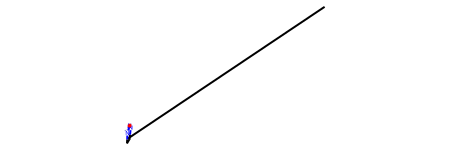

In [136]:
triazole_assign_order

SINGLE
AROMATIC
AROMATIC


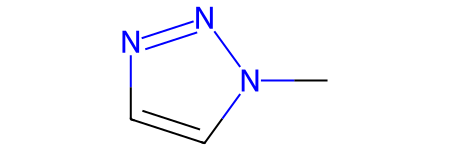

In [137]:
for atom in triazole_from_smi.GetAtoms():
    if len(atom.GetBonds()) == 3:
        for b in atom.GetBonds():
            print(b.GetBondType())
Chem.SanitizeMol(triazole_from_smi)
triazole_from_smi


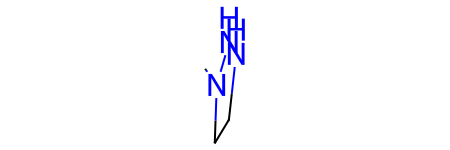

In [143]:
triazole_from_pdb = Chem.MolFromPDBFile("triazole.pdb",proximityBonding=False)
triazole_from_pdb

In [153]:
triazole_from_pdb = Chem.MolFromPDBFile("triazole.pdb",proximityBonding=False)
for atom in triazole_from_pdb.GetAtoms():
    name = Chem.AtomPDBResidueInfo.GetName(atom.GetPDBResidueInfo())
    atom_idx = atom.GetIdx()
    neighors = atom.GetNeighbors()
    neighors_idx = [at.GetIdx() for at in neighors]
    print(f"{atom_idx} {name} {neighors_idx}")

0  CAV [1]
1  NAU [2, 0, 3]
2  CAT [5, 1]
3  NAD [4, 1]
4  NAC [5, 3]
5  CAS [4, 2]


ref bond after:SINGLE False
ref bond after:AROMATIC True
ref bond after:AROMATIC True
ref bond after:AROMATIC True
ref bond after:AROMATIC True
ref bond after:AROMATIC True


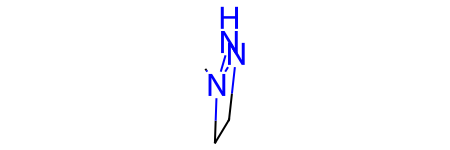

In [116]:
def AssignBond_inhouse(refmol, mol):
  refmol2 = Chem.rdchem.Mol(refmol)
  mol2 = Chem.rdchem.Mol(mol)
  # do the molecules match already?
  matching = mol2.GetSubstructMatch(refmol2)
  if not matching:  # no, they don't match
    # check if bonds of mol are SINGLE
    for b in mol2.GetBonds():
      # print(f"ref bond before:{b.GetBondType()} {b.GetIsAromatic()}")
      if b.GetBondType() != Chem.rdchem.BondType.SINGLE:
        b.SetBondType(Chem.rdchem.BondType.SINGLE)
        b.SetIsAromatic(False)
    # set the bonds of mol to SINGLE
    for b in refmol2.GetBonds():
      # print(f"inp bond before:{b.GetBondType()} {b.GetIsAromatic()}")
      b.SetBondType(Chem.rdchem.BondType.SINGLE)
      b.SetIsAromatic(False)
    # set atom charges to zero;
    for a in refmol2.GetAtoms():
      a.SetFormalCharge(0)
    for a in mol2.GetAtoms():
      a.SetFormalCharge(0)

    matching = mol2.GetSubstructMatches(refmol2, uniquify=True)
    # do the molecules match now?
    if matching:
      matching = matching[0]
      # apply matching: set bond properties
      for b in refmol.GetBonds():
        print(f"ref bond after:{b.GetBondType()} {b.GetIsAromatic()}")
        atom1 = matching[b.GetBeginAtomIdx()]
        atom2 = matching[b.GetEndAtomIdx()]
        b2 = mol2.GetBondBetweenAtoms(atom1, atom2)
        b2.SetBondType(b.GetBondType())
        b2.SetIsAromatic(b.GetIsAromatic())
      # apply matching: set atom properties
      for a in refmol.GetAtoms():
        a2 = mol2.GetAtomWithIdx(matching[a.GetIdx()])
        a2.SetHybridization(a.GetHybridization())
        a2.SetIsAromatic(a.GetIsAromatic())
        a2.SetNumExplicitHs(a.GetNumExplicitHs())
        a2.SetFormalCharge(a.GetFormalCharge())
      # Chem.SanitizeMol(mol2,sanitizeOps=Chem.rdmolops.SanitizeFlags.SANITIZE_NONE) 
      if hasattr(mol2, '__sssAtoms'):
        mol2.__sssAtoms = None  # we don't want all bonds highlighted
    else:
      raise ValueError("No matching found")
  return mol2
triazole_assign_order = AssignBond_inhouse(triazole_from_smi,triazole_from_pdb)
triazole_assign_order

In [ ]:
def get_connect_atom_in_core(orimol,sidechain_atom_idxes):
    # mol is the whole molecule, the sidechain_atom_idx is the a tuple of the atom idx of a sidechain;
    # this function will get the atom connected with the .
    connect_atoms_in_core = []
    for idx in sidechain_atom_idxes:
        for atom in orimol.GetAtomWithIdx(idx).GetNeighbors():
            if atom.GetIdx() not in sidechain_atom_idxes:
                connect_atoms_in_core.append(atom.GetIdx())
    return connect_atoms_in_core

In [ ]:
def get_connect_atom_in_sidechain(orimol,core):
    rings = orimol.GetRingInfo()
    for r in rings.AtomRings():
        count = 0
        for idx in core:
            if idx in set(r):
                count += 1
        if count == len(core) - 2:
            core_atom_idx = set(r)
            connect_atom_in_sidechain = set(core) - core_atom_idx
    return list(connect_atom_in_sidechain)


In [ ]:
def phe2bch_test(smi):
    # 用于将给定配体中的*间位苯环骨架*替换为*螺旋桨烷骨架*的脚本
    # 用smi指定ligand的结构

    # 读入分子
    mol = Chem.MolFromSmiles(smi)
    # 识别间位取代部分: * 匹配任意原子；'!:' 非芳香键； *!:ccc(!:*)ccc 含间位取代的苯环
    patt = Chem.MolFromSmarts("*!:ccc(!:*)ccc")
    match = mol.GetSubstructMatches(patt)
    
    # 识别两个间位取代基与苯环的连接原子
    connect_atoms = get_connect_atom_in_sidechain(mol,match[0])
    # 识别需要被替换苯环原子
    core = set(match[0])-set(connect_atoms)

    # 记录第一部分的原子数目
    mol1_Atom_num = mol.GetNumAtoms()

    # 引入螺旋桨烷，并将其与原分子置于一处，使得其编号从·mol1_Atom_num+0·开始
    re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")
    mid_mol = Chem.CombineMols(mol,re_pat)
    mid_edited = Chem.EditableMol(mid_mol)

    # 开始成键,螺旋桨烷烃的桥头碳分别为mol1_Atom_num和mol1_Atom_num+4
    mid_edited.AddBond(connect_atoms[0],mol1_Atom_num,order=Chem.rdchem.BondType.SINGLE)
    mid_edited.AddBond(connect_atoms[1],mol1_Atom_num+4,order=Chem.rdchem.BondType.SINGLE)
    # 删除原来的苯环,每删除一个原子后原子序号都会发生改变，所以需要倒序删除。
    phenyl_atoms = list(core)
    phenyl_atoms.sort(reverse=True)
    for i in phenyl_atoms:
        mid_edited.RemoveAtom(i)
    BCHep_mol = mid_edited.GetMol()
    return BCHep_mol

test = phe2bch_test("CN1C(=O)C=C(N=C1N)[C@H]2C[C@H]2c3cccc(c3)c4cccc(c4)OC")
mol_with_atom_index(test)

In [ ]:
def copy_partconf(refmol,refconf,partsmi,inpmol,inpconf,inpff):
    # introduct a middle mol for 
    partmol = Chem.MolFromSmarts(partsmi)
    partmol = Chem.AddHs(partmol)
    AllChem.EmbedMolecule(partmol)
    partmol = Chem.RemoveAllHs(partmol)
    partconf = partmol.GetConformer()

    # copy conf from refmol to middle mol
    mcs_ref2part = rdFMCS.FindMCS([refmol, partmol],timeout=3)
    for i, j in zip(refmol.GetSubstructMatch(mcs_ref2part),partmol.GetSubstructMatch(mcs_ref2part)):
        partconf.SetAtomPosition(j,refconf.GetAtomPosition(i))
    mcs_part2inp = rdFMCS.FindMCS([inpmol, partmol],timeout=3)
    
    # copy conf from middle mol to inpmol
    for i, j in zip(partmol.GetSubstructMatch(mcs_part2inp),inpmol.GetSubstructMatch(mcs_part2inp)):
        inpff.AddFixedPoint(j)
        inpconf.SetAtomPosition(j,partconf.GetAtomPosition(i))
    return 0



In [ ]:
def getpdb_test(refmol,inpmol,pdbfile):
    
    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    if inpmol_prop:
        ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol,inpmol_prop)
    else:
        ff_mcs = Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(inpmol)


    core = Chem.MolFromSmiles("C12CCCC(C2)C1")
    side_chains, unmatched = rdRGD.RGroupDecompose([core],[inpmol])
    for R in ['R1','R2']:
        sidechain = side_chains[0][R]
        sidechain_conf = sidechain.GetConformer()

        mcs_ref2mid = rdFMCS.FindMCS([refmol, sidechain],timeout=3,bondCompare=rdFMCS.BondCompare.CompareAny)
        for i, j in zip(refmol.GetSubstructMatch(mcs_ref2mid.queryMol),sidechain.GetSubstructMatch(mcs_ref2mid.queryMol)):
            sidechain_conf.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
        
        mcs_mid2inp = rdFMCS.FindMCS([inpmol, sidechain],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
        for i, j in zip(sidechain.GetSubstructMatch(mcs_mid2inp.queryMol),inpmol.GetSubstructMatch(mcs_mid2inp.queryMol)):
            try:
                ff_mcs.AddFixedPoint(j)
                conf_res.SetAtomPosition(j, sidechain_conf.GetAtomPosition(i))
            except:
                print(f"error {inpmol.GetAtomWithIdx(j).GetSymbol()}")
        
        mcs1 = rdFMCS.FindMCS([refmol, sidechain],timeout=3,bondCompare=rdFMCS.BondCompare.CompareAny)
        mcs3 = rdFMCS.FindMCS([inpmol, sidechain],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
        sidechain_ref = refmol.GetSubstructMatch(mcs1.queryMol)
        sidechain_gen = inpmol.GetSubstructMatch(mcs3.queryMol)
        atom_connect_sidechain_core_ref = get_connect_atom_in_core(refmol, sidechain_ref)[0]
        atom_connect_sidechain_core_gen = get_connect_atom_in_core(inpmol, sidechain_gen)[0]
        ff_mcs.AddFixedPoint(atom_connect_sidechain_core_gen)
        conf_res.SetAtomPosition(atom_connect_sidechain_core_gen,bonded_conf.GetAtomPosition(atom_connect_sidechain_core_ref))
        
    for i in range(6):
        try:
            ff_mcs.Minimize()
        except:
            pass

#    for i, j in zip(refmol.GetSubstructMatch(mcs.queryMol), inpmol.GetSubstructMatch(mcs.queryMol)):
#        ff_mcs.AddFixedPoint(j)
#        conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
#    for i in range(10):
#        try:
#            ff_mcs.Minimize()
#        except:
#            pass
    Chem.MolToPDBFile(inpmol, pdbfile)
    return inpmol

In [ ]:
def phe2bch_topdb_test(smi0,refpdb,name):
    mol = phe2bch_test(smi0)
    smi = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    mol = Chem.RemoveAllHs(mol)

    structure_from_pdb = Chem.MolFromPDBBlock(refpdb)
    structure_from_pdb = Chem.RemoveAllHs(structure_from_pdb)
    mol_tem = Chem.MolFromSmiles(smi0)
    try:
        structure_refine = AllChem.AssignBondOrdersFromTemplate(mol_tem,structure_from_pdb)
    except:
        structure_refine = structure_from_pdb
    return getpdb_test(structure_refine,mol,f"{name}")

In [ ]:
key='PIX'
pdbid='3lj6'
lig_smi=ligands_smi[key][0]
pdb_file_path=f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdbid}.ent"
lig_Block = pdb_2_lig_block(pdb_file_path,key,lig_smi)
ligand_text = []
with open(pdb_file_path) as pdb:
    for line in pdb:
        if line[0:6] == "HETATM" and "HOH" not in line and "WAT" not in line and "SO4" not in line:
            ligand_text.append(line)
lig_re_test = "".join(ligand_text) 
mol = Chem.MolFromSmiles(lig_smi)
# test = phe2bch_topdb_test(lig_smi,lig_Block,f"{key}_{pdbid}.pdb")
drawit(test)



In [ ]:
mol_file = Chem.MolFromPDBBlock(lig_Block,sanitize=False,flavor=1)
Chem.AddHs(mol_file)
mol_file

In [ ]:
smi0,refpdb,name = lig_smi,lig_Block,f"{key}_{pdbid}.pdb"
mol = phe2bch_test(smi0)
smi = Chem.MolToSmiles(mol)
mol = Chem.MolFromSmiles(smi)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
mol = Chem.RemoveAllHs(mol)

structure_from_pdb = Chem.MolFromPDBBlock(refpdb)
structure_from_pdb = Chem.RemoveAllHs(structure_from_pdb)
mol_tem = Chem.MolFromSmiles(smi0)
mol_tem = Chem.RemoveHs(mol_tem,sanitize=False)
try:
    structure_refine = AllChem.AssignBondOrdersFromTemplate(mol_tem,structure_from_pdb)
except:
    structure_refine = structure_from_pdb


In [ ]:
mol_tem

In [ ]:
mol

In [ ]:
refmol,inpmol,pdbfile =structure_refine,mol,f"{name}"
    
bonded_conf = refmol.GetConformer()
conf_res = inpmol.GetConformer()
inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol,mmffVariant='MMFF94s')
ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol,inpmol_prop)
print(ff_mcs)

In [ ]:
core = Chem.MolFromSmiles("C12CCCC(C2)C1")
res, unmatched = rdRGD.RGroupDecompose([core],[inpmol])
mol_with_atom_index(refmol)
drawit(res[0]['R2'])
Chem.MolFromSmiles(Chem.MolToSmiles(res[0]['R2']).replace("[*:2]",'').replace("[*:1]",''))

In [ ]:
drawit(refmol)

In [ ]:
mol_with_atom_index(refmol)

In [ ]:
mcs1 = rdFMCS.FindMCS([refmol, res[0]['R2']],timeout=5,bondCompare=rdFMCS.BondCompare.CompareAny)
mcs3 = rdFMCS.FindMCS([inpmol, res[0]['R2']],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
sidechain_ref = refmol.GetSubstructMatch(mcs1.queryMol)
sidechain_gen = inpmol.GetSubstructMatch(mcs3.queryMol)
print(sidechain_ref)
print(sidechain_gen)

atom_connect_sidechain_core_gen = get_connect_atom_in_core(inpmol, sidechain_gen)[0]

drawit(refmol)
drawit(res[0]['R2'])
mcs1.queryMol


In [ ]:
test_smi = Chem.MolToSmiles(res[0]['R2'])
side_chain_mol = Chem.MolFromSmiles(test_smi)
mcs2 = rdFMCS.FindMCS([refmol, side_chain_mol],timeout=5,ringCompare=Chem.rdFMCS.RingCompare.StrictRingFusion)
mcs2.queryMol
sidechain_ref = refmol.GetSubstructMatch(mcs2.queryMol)
sidechain_ref

In [ ]:
for R in ['R1','R2']:
    mcs1 = rdFMCS.FindMCS([refmol, res[0][R]],timeout=3,)
    mcs3 = rdFMCS.FindMCS([inpmol, res[0][R]],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
    sidechain_ref = refmol.GetSubstructMatch(mcs1.queryMol)
    sidechain_gen = inpmol.GetSubstructMatch(mcs3.queryMol)
    for i, j in zip(sidechain_ref,sidechain_gen):
        # print(f"{R} {i} {j}")
        ff_mcs.AddFixedPoint(j)
        conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
    atom_connect_sidechain_core_ref = get_connect_atom_in_core(refmol, sidechain_ref)[0]
    atom_connect_sidechain_core_gen = get_connect_atom_in_core(inpmol, sidechain_gen)[0]
    print(atom_connect_sidechain_core_gen)
    ff_mcs.AddFixedPoint(atom_connect_sidechain_core_gen)
    conf_res.SetAtomPosition(atom_connect_sidechain_core_gen,bonded_conf.GetAtomPosition(atom_connect_sidechain_core_ref))

In [ ]:
drawit(inpmol)

In [ ]:
pdb = Chem.MolFromPDBBlock(lig_Block)
drawit(pdb)

In [ ]:
def phe2bch_with_smiles(smi):
    # 用于将给定配体中的*间位苯环骨架*替换为*螺旋桨烷骨架*的脚本
    # 用smi指定ligand的结构

    # 读入分子
    mol = Chem.MolFromSmiles(smi)
    # 识别间位取代部分: * 匹配任意原子；'!:' 非芳香键； *!:ccc(!:*)ccc 含间位取代的苯环
    patt = Chem.MolFromSmarts("*!:ccc(!:*)ccc")
    match = mol.GetSubstructMatches(patt)
    
    # 识别需要被替换苯环原子
    ri = mol.GetRingInfo()
    for r in ri.AtomRings():
        count = 0
        for item in match[0]:
            if item in set(r):
                count+=1
        if count == len(match[0])-2:
            phenyl_num = set(r)
    # 识别两个间位取代基与苯环的连接原子
    connect_atoms = list(set(match[0])-phenyl_num)
    # 记录第一部分的原子数目
    mol1_Atom_num = mol.GetNumAtoms()
    # 引入螺旋桨烷，并将其与原分子置于一处，使得其编号从·mol1_Atom_num+0·开始
    re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")
    mid_mol = Chem.CombineMols(mol,re_pat)
    # 开始成键
    mid_edited = Chem.EditableMol(mid_mol)
    # 螺旋桨烷烃的桥头碳分别为mol1_Atom_num和mol1_Atom_num+4
    mid_edited.AddBond(connect_atoms[0],mol1_Atom_num,order=Chem.rdchem.BondType.SINGLE)
    mid_edited.AddBond(connect_atoms[1],mol1_Atom_num+4,order=Chem.rdchem.BondType.SINGLE)
    # 删除原来的苯环
    # 每删除一个原子后原子序号都会发生改变，所以需要倒序删除。
    phenyl_atoms = list(phenyl_num)
    phenyl_atoms.sort(reverse=True)
    for i in phenyl_atoms:
        mid_edited.RemoveAtom(i)
    BCHep_mol = mid_edited.GetMol()
    return [BCHep_mol,mol1_Atom_num-6]  

test = phe2bch_with_smiles("Cc1c(sc(n1)N)c2ccnc(n2)Nc3cccc(c3)n4oo4")

In [ ]:
def getpdb(refmol,inpmol,pdbfile):
    mcs = rdFMCS.FindMCS([refmol, inpmol],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol,inpmol_prop)
    for i, j in zip(refmol.GetSubstructMatch(mcs.queryMol), inpmol.GetSubstructMatch(mcs.queryMol)):
        ff_mcs.AddFixedPoint(j)
        conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
    Chem.MolToPDBFile(inpmol, pdbfile)
    return inpmol
